# xray_detection 
### 任务：训练模型正确识别肺炎X光图片，0=正常，1=肺炎


## 拿到数据，首先还是要可视化看一下部分数据吧！

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
rootdir = "C:/Users/dell1/Desktop/hahaha/bs/xray_dataset/train/"

### 可视化部分训练数据的阳性和阴性数据

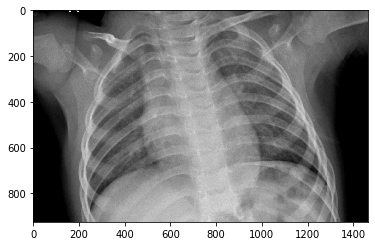

In [31]:
img_mormal_path = os.path.join(rootdir,"NORMAL/1.jpeg")
img_mormal = plt.imread(img_mormal_path)
plt.imshow(img_mormal, cmap="gray")
plt.show()

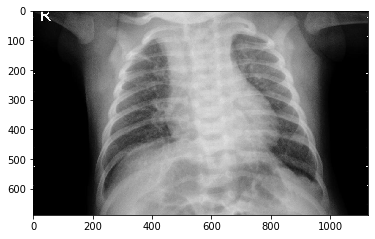

In [32]:
img_mormal_path = os.path.join(rootdir,"PNEUMONIA/2.jpeg")
img_mormal = plt.imread(img_mormal_path)
plt.imshow(img_mormal, cmap="gray")
plt.show()

### 额，，，貌似看不出什么！尴尬！
#### 那接下来看一下数据分布等其他信息吧

In [33]:
train_path = "C:/Users/dell1/Desktop/hahaha/bs/xray_dataset/train/"
test_path = "C:/Users/dell1/Desktop/hahaha/bs/xray_dataset/test/"

In [35]:
img_mormal.shape

(688, 1128)

#### 首先把数据都保存在csv文件中

In [36]:
def get_all_path(rootdir):
    """
    获取文件夹下的所有文件路径
    rootdir：是当前目录
    return：返回当前目录下所有的文件路径
    """
    path_list = []
    all_path = os.listdir(rootdir)
    for i in range(0,len(all_path)):
        path = os.path.join(rootdir, all_path[i])
        path_list.append(path)
    return path_list

In [58]:
df_path = "./train.csv"
path_list = get_all_path("C:/Users/dell1/Desktop/hahaha/bs/xray_dataset/train/PNEUMONIA")
df0 = pd.DataFrame()
df0["path_list"] = path_list
df0["label"] = 0

path_list = get_all_path("C:/Users/dell1/Desktop/hahaha/bs/xray_dataset/train/NORMAL")
df1 = pd.DataFrame()
df1["path_list"] = path_list
df1["label"] = 1

df = pd.concat([df0, df1])
df.to_csv(df_path, index = False)

In [59]:
df_path = "./test.csv"
path_list = get_all_path("C:/Users/dell1/Desktop/hahaha/bs/xray_dataset/test")
df = pd.DataFrame()
df["path_list"] = path_list
df["label"] = 0
df.to_csv(df_path, index = False)

#### 好了，搞定了，那么看一下数据的各种属性吧

In [60]:
train = "train.csv"
test = "test.csv"

In [62]:
train = pd.read_csv(train) #4098个数据集
test = pd.read_csv(test) # 1757个数据集

In [83]:
train[train["label"]==1].count()

path_list    1112
label        1112
dtype: int64

In [84]:
train[train["label"]==0].count()

path_list    2987
label        2987
dtype: int64

####  额， 看起来貌似正负样本不均衡。。。—_—

#### 先不管了 扔进模型出个结果再说， 站在巨人的肩膀上，往往会看的更远，，，所以我选择在Resnet50做fine tuning 

In [ ]:

from keras.models import Model
from keras.layers import Dense
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator


# 训练的batch_size
batch_size = 16
# 训练的epoch
epochs = 100

# 图像Generator，用来构建输入数据
train_datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True)

# 从文件中读取数据，目录结构应为train下面是各个类别的子目录，每个子目录中为对应类别的图像
train_generator = train_datagen.flow_from_directory('./train', target_size = (224, 224), batch_size = batch_size)

# 训练图像的数量
image_numbers = 4098

# 输出类别信息
print train_generator.class_indices

# 生成测试数据
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory('./validation', target_size = (224, 224), batch_size = batch_size)

# 使用ResNet的结构，不包括最后一层，且加载ImageNet的预训练参数
base_model = ResNet50(weights = 'imagenet', include_top = False, pooling = 'avg')

# 构建网络的最后一层，3是自己的数据的类别
predictions = Dense(2, activation='softmax')(base_model.output)

# 定义整个模型
model = Model(inputs=base_model.input, outputs=predictions)

# 编译模型，loss为交叉熵损失
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 训练模型
model.fit_generator(train_generator,steps_per_epoch = image_numbers // batch_size, epochs = epochs, validation_data = validation_generator, validation_steps = batch_size)

# 保存训练得到的模型
model.save_weights('weights.h5')

#### 最后就是预测和保存预测结果了

In [86]:
predict = model.predict("test")
df = pd.DataFrame()
index = []
for i in range(1, len(test+1)):
    index.append(i)

df.id = index
df.label = predict
df.to_csv("submission.csv", head=False)